# 0. 데이터 준비
- 캐글 __Dogs vs. Cats__ 데이터셋 
- https://www.kaggle.com/c/dogs-vs-cats/data 에서 다운로드 가능 (캐글 로그인 필요)
- 다운로드 받은 데이터셋 파일(dogs-vs-cats.zip) 압축해제 및 그 안의 train.zip 파일 압축해제

In [1]:
import glob
import numpy as np
import pandas as pd
import os
import shutil
#from utils import log_progress

np.random.seed(42)

In [2]:
## 데이터 경로
files = glob.glob('train/*')
files[:10]

['train\\cat.0.jpg',
 'train\\cat.1.jpg',
 'train\\cat.10.jpg',
 'train\\cat.100.jpg',
 'train\\cat.1000.jpg',
 'train\\cat.10000.jpg',
 'train\\cat.10001.jpg',
 'train\\cat.10002.jpg',
 'train\\cat.10003.jpg',
 'train\\cat.10004.jpg']

In [3]:
## 파일명을 통해 cat 파일, dog 파일 분리
cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]

len(cat_files), len(dog_files)

(12500, 12500)

In [4]:
# 이렇게 한번에 해도 됨...
# cat_files = glob.glob('train/cat.*') 
# dog_files = glob.glob('train/dog.*') 

In [5]:
## 학습데이터/검증데이터/테스트데이터 분리 
# cf) sklearn의 sklearn.model_selection.train_test_split() 사용하면 편리 (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [6]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


## 학습데이터/검증데이터/테스트데이터 각각 별도의 파일을 만들어서 저장
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

# cat, dog 데이터를 결합
train_files = np.concatenate([cat_train, dog_train]) 
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

# 각 경로가 없으면 새로 만듦.
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

# 학습데이터/검증데이터/테스트데이터 경로에 원본 파일 복사
for fn in log_progress(train_files, name='Training Images'):
    shutil.copy(fn, train_dir)

for fn in log_progress(validate_files, name='Validation Images'):
    shutil.copy(fn, val_dir)
    
for fn in log_progress(test_files, name='Test Images'):
    shutil.copy(fn, test_dir)

# 1. 합성곱 신경망(CNN) 모델 처음부터 구축하기

In [7]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img

Using TensorFlow backend.
C:\Users\heine\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\heine\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\heine\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\heine\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## 1) 데이터 불러오기

In [8]:
## 학습 데이터 / 검증 데이터 준비
# 이미지의 가로,세로 사이즈는 150,150이고 빨강, 녹색, 파랑(RGB)인 3개의 채널이 있으므로 
# 출력되는 shape은 (데이터 갯수, 150, 150, 3)의 형태. 

IMG_DIM = (150, 150)

# 학습 데이터 
train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

# 검증 데이터
validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\nValidation dataset shape:', validation_imgs.shape) 

Train dataset shape: (3000, 150, 150, 3) 
Validation dataset shape: (7524, 150, 150, 3)


(150, 150, 3)


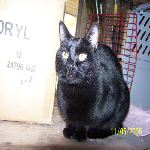

In [9]:
## 데이터 샘플 확인
print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [10]:
## 텍스트 클래스 레이블 인코딩
# cat : 0, dog : 1
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print('Before Encoding : ', train_labels[1495:1505], 
      '\nAfter Encoding : ', train_labels_enc[1495:1505])

Before Encoding :  ['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog'] 
After Encoding :  [0 0 0 0 0 1 1 1 1 1]


## 2) 데이터 증강 

In [11]:
train_files = glob.glob('training_data/*')
train_files[:10]

['training_data\\cat.10003.jpg',
 'training_data\\cat.10009.jpg',
 'training_data\\cat.10013.jpg',
 'training_data\\cat.10024.jpg',
 'training_data\\cat.10026.jpg',
 'training_data\\cat.10031.jpg',
 'training_data\\cat.10033.jpg',
 'training_data\\cat.10039.jpg',
 'training_data\\cat.10041.jpg',
 'training_data\\cat.1005.jpg']

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


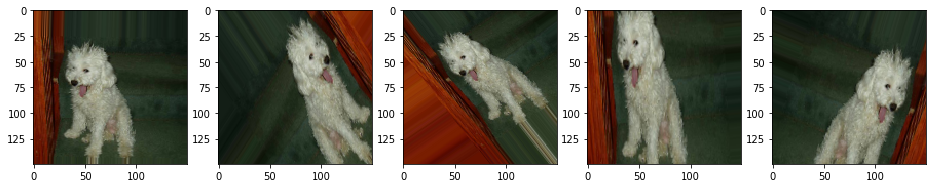

In [13]:
## 데이터 증강된 고양이 이미지 샘플
img_id = 2595
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


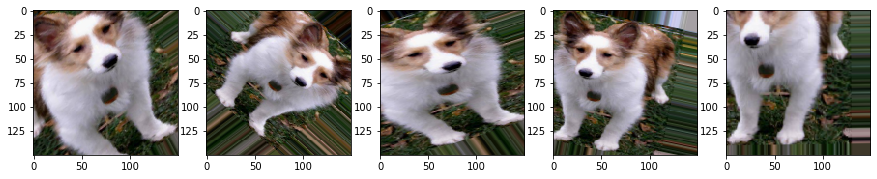

In [14]:
## 데이터 증강된 강아지 이미지 샘플
img_id = 1991
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

## 3) 모델 정의

In [15]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

In [16]:
## 하이퍼 파라미터 설정
batch_size = 100 # 배치 사이즈 : 반복해서 모델에 전달되는 데이터의 수
num_classes = 2 # 클래스 개수 (cat, dog)
#epochs = 100 # 에포크 : 학습하는동안 모델에 전달하는 전체 데이터 세트를 횟수
epochs = 3 # 에포크 : 학습하는동안 모델에 전달하는 전체 데이터 세트를 횟수
input_shape = (150, 150, 3) # 입력되는 이미지 사이즈 (가로사이즈, 세로사이즈, 채널 수)

In [17]:
## CNN 모델 컴파일 및 요약 정보 확인
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

W1119 10:55:12.143630 23620 deprecation_wrapper.py:119] From C:\Users\heine\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1119 10:55:12.216436 23620 deprecation_wrapper.py:119] From C:\Users\heine\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1119 10:55:12.227407 23620 deprecation_wrapper.py:119] From C:\Users\heine\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1119 10:55:12.251343 23620 deprecation_wrapper.py:119] From C:\Users\heine\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1119 10:55:12.306196 23620 deprecation_wrapper.py:119] From C:\Users\heine\Ana

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## 4) 모델 학습

In [18]:
## 모델 학습
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=batch_size)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=batch_size)

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=epochs,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/3
100/100 [==============================] - 183s 2s/step - loss: 0.6954 - acc: 0.5264 - val_loss: 0.6854 - val_acc: 0.5390
Epoch 2/3
100/100 [==============================] - 210s 2s/step - loss: 0.6848 - acc: 0.5697 - val_loss: 0.6746 - val_acc: 0.5717
Epoch 3/3
100/100 [==============================] - 206s 2s/step - loss: 0.6736 - acc: 0.5979 - val_loss: 0.7395 - val_acc: 0.6084


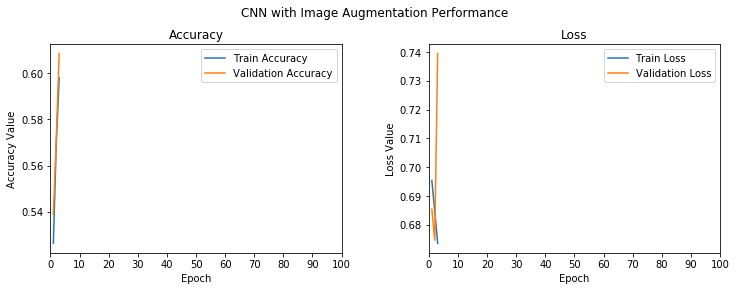

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, epochs+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [20]:
model.save('cats_dogs_cnn_img_aug.h5')

# 2. 사전 훈련된 CNN 모델에 전이학습 활용하기
- VGG-16 : https://arxiv.org/pdf/1409.1556.pdf

## 1) 데이터 불러오기 (위와 동일)

In [21]:
## 학습 데이터 / 검증 데이터 준비
# 이미지의 가로,세로 사이즈는 150,150이고 빨강, 녹색, 파랑(RGB)인 3개의 채널이 있으므로 
# 출력되는 shape은 (데이터 갯수, 150, 150, 3)의 형태. 

IMG_DIM = (150, 150)

# 학습 데이터 
train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

# 검증 데이터
validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\nValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 
Validation dataset shape: (7524, 150, 150, 3)


## 2) 데이터 증강 (위와 동일)

In [22]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

## 3) 모델 정의

In [23]:
## 하이퍼 파라미터 설정
batch_size = 30 # 배치 사이즈 : 반복해서 모델에 전달되는 데이터의 수
num_classes = 2 # 클래스 개수 (cat, dog)
#epochs = 100 #100 # 에포크 : 학습하는동안 모델에 전달하는 전체 데이터 세트를 횟수
epochs = 3 #100 # 에포크 : 학습하는동안 모델에 전달하는 전체 데이터 세트를 횟수
input_shape = (150, 150, 3) # 입력되는 이미지 사이즈 (가로사이즈, 세로사이즈, 채널 수)

In [24]:
## 사전 학습된 VGG-16 모델 불러오기
import keras
from keras.models import Model
from keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [25]:
# VGG-16 모델의 층이 고정되었는지 확인
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002A6000A8AC8>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x000002A6000A8710>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000002A6BE1EFDD8>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000002A75A137710>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000002A600038710>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000002A60015B5F8>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000002A69E79DCC0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000002A69E79DD30>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000002A6918F7550>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000002A691927A90>,block3_conv3,False


In [26]:
# VGG-16의 합성곱 블록 4와 5가 학습 가능하도록 설정
vgg_model.trainable = True
set_trainable = False

for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [27]:
# VGG-16 모델의 층이 학습 가능한지 확인

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002A6000A8AC8>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x000002A6000A8710>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000002A6BE1EFDD8>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000002A75A137710>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000002A600038710>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000002A60015B5F8>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000002A69E79DCC0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000002A69E79DD30>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000002A6918F7550>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000002A691927A90>,block3_conv3,False


In [28]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5), 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
________________________________________________________

## 4) 모델 학습

In [29]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=batch_size)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=batch_size)

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=epochs,
                              validation_data=val_generator, validation_steps=50, verbose=1)


Epoch 1/3
100/100 [==============================] - 676s 7s/step - loss: 0.5925 - acc: 0.6667 - val_loss: 0.2960 - val_acc: 0.8673
Epoch 2/3
100/100 [==============================] - 694s 7s/step - loss: 0.3873 - acc: 0.8303 - val_loss: 0.2077 - val_acc: 0.9033
Epoch 3/3
100/100 [==============================] - 690s 7s/step - loss: 0.3265 - acc: 0.8653 - val_loss: 0.1789 - val_acc: 0.9193


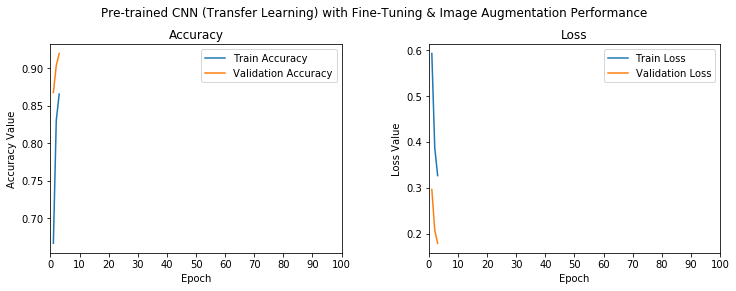

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, epochs+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [31]:
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

# 3. 모델 성능 평가

In [32]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu

In [33]:
img_aug_cnn = load_model('cats_dogs_cnn_img_aug.h5')
tl_img_aug_finetune_cnn = load_model('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

In [34]:
## 이미지 기본 모양
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]

## 1) 샘플 테스트 이미지로 모델 예측

In [50]:
sample_img_path = ".\\validation_data\\dog.10399.jpg"
#sample_img_path = 'my_cat.jpg'
# sample_img_path = 'dog1.jpg'
#sample_img_path = 'dog2.jpg'
#sample_img_path = 'trump1.jpg'

sample_img = load_img(sample_img_path, target_size=IMG_DIM)
sample_img_tensor = img_to_array(sample_img)
sample_img_tensor = np.expand_dims(sample_img_tensor, axis=0)
sample_img_tensor /= 255.

print(sample_img_tensor.shape)

(1, 150, 150, 3)


In [51]:
cnn_img_aug_prediction = num2class_label_transformer(img_aug_cnn.predict_classes(sample_img_tensor, verbose=0))
tlearn_cnn_finetune_img_aug_prediction = num2class_label_transformer(tl_img_aug_finetune_cnn.predict_classes(sample_img_tensor, verbose=0))
print('Predictions for our sample image:\n', 
      '\nCNN with Img Augmentation:', cnn_img_aug_prediction, 
      '\nPre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning):', tlearn_cnn_finetune_img_aug_prediction)

Predictions for our sample image:
 
CNN with Img Augmentation: ['dog'] 
Pre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning): ['dog']


In [52]:
img_aug_cnn.predict_proba(sample_img_tensor, verbose=0)

array([[0.6814226]], dtype=float32)

In [53]:
tl_img_aug_finetune_cnn.predict_proba(sample_img_tensor, verbose=0)

array([[0.6377304]], dtype=float32)

## 2) CNN 모델이 인지한 것을 시각화하기

In [ ]:
tl_img_aug_finetune_cnn.layers[0].layers[1:9]

In [ ]:
from keras import models  

In [ ]:
# 최상위 8개 층에서 추출된 출력:
layer_outputs = [layer.output for layer in tl_img_aug_finetune_cnn.layers[0].layers[1:9]]

# 모델 입력에 따라 출력을 반환하는 모델을 생성:
activation_model = models.Model(inputs=tl_img_aug_finetune_cnn.layers[0].layers[1].input, outputs=layer_outputs)

# 층마다 배열이 1개이므로 numpy 배열 형태로 8개의 리스트를 반환
activations = activation_model.predict(sample_img_tensor)

In [ ]:
print ('Sample layer shape:', activations[0].shape)
print('Sample convolution (activation map) shape:', activations[0][0, :, :, 1].shape)

In [ ]:
## 샘플 특성 지도 추출
fig, ax = plt.subplots(1,5, figsize=(16, 6))
ax[0].imshow(activations[0][0, :, :, 10], cmap='bone')
ax[1].imshow(activations[0][0, :, :, 25], cmap='bone')
ax[2].imshow(activations[0][0, :, :, 40], cmap='bone')
ax[3].imshow(activations[0][0, :, :, 55], cmap='bone')
ax[4].imshow(activations[0][0, :, :, 63], cmap='bone')

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in tl_img_aug_finetune_cnn.layers[0].layers[1:9]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='bone')

- 최상위 층의 특성지도가 원래의 이미지를 더 많이 유지.
- 깊은 층 일수록 특성지도는 더 추상적이고 복잡해지며 해석이 어려워짐.

## 3) 테스트 데이터로 수행한 평가 모델 성능

In [ ]:
IMG_DIM = (150, 150)

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in test_files]

test_labels_enc = class2num_label_transformer(test_labels)

print('Test dataset shape:', test_imgs.shape)

In [ ]:
## 데이터 노말라이즈(스케일링) 및 레이블 인코딩
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

test_labels_enc = class2num_label_transformer(test_labels)

print(test_labels[0:5], test_labels_enc[0:5])

In [ ]:
## 학습 할때처럼 generator를 활용하여 예측하는 것도 가능.
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow(test_imgs, test_labels_enc, batch_size=batch_size, shuffle=False)
# predictions = img_aug_cnn.predict_generator(test_generator, verbose=0)

In [ ]:
## 주어진 데이터만으로 학습한 CNN 모델 (img_aug_cnn) 성능
predictions = img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, classes=list(set(test_labels)))

In [ ]:
"""
## VGG-16기반으로 전이학습한 CNN 모델 (tl_img_aug_finetune_cnn) 성능
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, classes=list(set(test_labels)))
"""

In [ ]:
"""
## ROC 커브 비교
meu.plot_model_roc_curve(img_aug_cnn, test_imgs_scaled, 
                                  true_labels=test_labels_enc, class_names=[0, 1])

meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                                  true_labels=test_labels_enc, class_names=[0, 1])
"""